# Here I will simply build a classifier that detects the presence of a red ball or not in the training imagaes.
    - First build classifier
    - Then try to do the sliding window thing.
    - I think the purpose of sliding window is so we know the new location of the ball. E.g. If we find ball in top right then move in that direction.

In [1]:
# imports
import os
import numpy as np
from PIL import Image   # https://www.pluralsight.com/guides/importing-image-data-into-numpy-arrays
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf

In [2]:
# Define dirs
pos_img_dir = 'TrainingImages/positives/'
neg_img_dir = 'TrainingImages/negatives/'

In [3]:
# Follow https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5
# Official https://www.tensorflow.org/tutorials/images/cnn


In [4]:
# go through negatives

neg_images = []
neg_labels = np.zeros( len( os.listdir(neg_img_dir) ) )

for filename in os.listdir(neg_img_dir):
    neg_images.append(np.array(Image.open(neg_img_dir + filename))/255 )  # Normal

#plt.imshow(neg_images[0])
np.shape(neg_images)

(2600, 51, 51, 3)

In [5]:
# go through positives

pos_images = []
pos_labels = np.ones( len( os.listdir(pos_img_dir) ) )

for filename in os.listdir(pos_img_dir):
    pos_images.append(np.array(Image.open(pos_img_dir + filename))/255 ) 

#plt.imshow(pos_images[0])
np.shape(pos_images)

(308, 51, 51, 3)

In [6]:
type(pos_images[0])
X = np.concatenate((neg_images, pos_images))

In [7]:
# Now weve got data in array form we can split into test and train data?
# With full colour images

X = np.concatenate((neg_images, pos_images))
y = np.concatenate((neg_labels, pos_labels))

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=300,
                                                    shuffle=True)

# Maybe TODO One-Hot-Encode CNN labels? Does it matter?
#Prove test and train data is split correctly
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train[0].shape

(2326, 51, 51, 3)
(2326,)
(582, 51, 51, 3)
(582,)


(51, 51, 3)

In [8]:
# Multiclass CNN Architecture from 
from tensorflow.keras import datasets, layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(51, 51, 3))) # Or input_shape=(X.shape[1:]) to get inshape
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu')) 

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))
#model.add(layers.Dense(2)) # If activation function is used on last layer then accuracy will only be 0.9 not 0.99  
# Keras Documentation:
# activation: Activation function to use (see activations). 
# If you don't specify anything, no activation is applied (ie. "linear" activation: a(x) = x).

model.summary()

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.fit(X_train, y_train, epochs=2, validation_data=(X_test, y_test))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 49, 49, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 30976)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1982528   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 2,002,050
Trainable params: 2,002,050
Non-trainable params: 0
______________________________________________

In [9]:
# Binary Classification CNN Architecture from 
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
# TODO Try their imageGenerator and ensure it will recognise half spheres and that stuff
from tensorflow.keras import datasets, layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), input_shape=(51, 51, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Only a single Conv layer
# Rationale is that there are no higher levels or complicated features to the detection problem.
# Probably detecting the ball as a solid object of red colour, nothing more complicated than that.

model.add(layers.Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))  # Prevent overfitting
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=2, validation_data=(X_test, y_test))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 49, 49, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 49, 49, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1179712   
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)               

In [10]:
dave = model.predict(X_test)
# compare with y_test in explorer

In [11]:
X_test.shape

(582, 51, 51, 3)

In [12]:
# Get first image to classify

import PacMan_functionality as PacMan

# Initialise game
global_cloud, spheres_collected = PacMan.startup_scene()
# Create current camera position and angle
position = np.zeros([3])
angle = np.zeros([3])

# Obtain image and associated maps
image, map1, map2, map3, map4 = PacMan.project_pointcloud_image(global_cloud, angle, position)

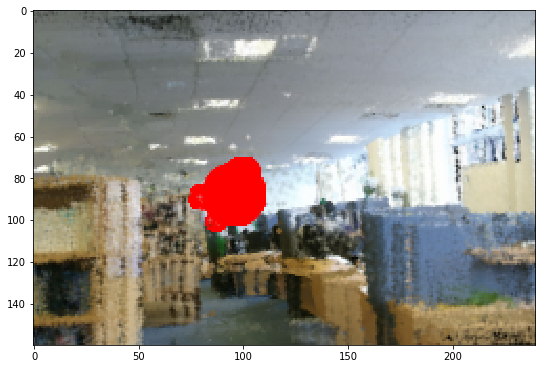

In [13]:
type(image)
np.shape(image)
plt.imshow(image)

In [14]:
print(image[0:51,0:51,:].shape)
print(X_test[0].shape)
#model.predict( [image[0:51,0:51,:]] )

# model.predict( np.array( [single_test,] )  ) # Correct syntax
model.predict( np.array( [image[0:51,0:51,:],] )  )
image.shape

(51, 51, 3)
(51, 51, 3)


(160, 240, 3)

In [15]:
# Define function sliding window
# returns array of windows that I can classify at once
def sliding_window( step_size, image ):
    #image is (160, 240, 3)
    #window is (51, 51, 3)
    image_hight = image.shape[0] # 160
    image_width = image.shape[1] # 240
    window_size = 51
    windows = []

    for y in range(0, image_hight-window_size, step_size):   # Verticle?
        for x in range (0, image_width-window_size, step_size):   #horizontal?
            windows.append(image[y:y+window_size, x:x+window_size, :])

    return np.array(windows) # Return windows as np array

res = sliding_window(1, image)
np.shape(res)

(20601, 51, 51, 3)

60
33
[[0.99960464]]
True


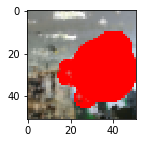

34
[[0.781379]]
True


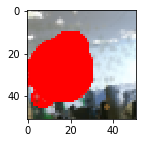

In [16]:
test = sliding_window(20, image)

def confidence_threshold(prediction):
    # Will return true if models confidence is above a threshold value
    threshold = 0.02
    if (prediction > threshold):
        return True
    else:
        return False

print(len(test[:,0,0,0]))

for i in range( len(test[:,0,0,0]) ):
    
    prediction = model.predict( np.array( [test[i,:,:,:],]) )

    if (confidence_threshold(prediction)==False):
        continue
    else:
        print(i)
        print(prediction)
        print(confidence_threshold(prediction))  
        #print( str(prediction).format(1.0e-9) ) # Force scientific notation off
        plt.figure(figsize=(4,2))
        plt.imshow(test[i,:,:,:])    
        plt.show()

In [17]:
# Try a new CNN with the input data augmented so it will classify obscured spheres
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.6,  #
        height_shift_range=0.6, # Incresead these so theyre high so theyll know to classify sphere if only half a sphere is showing
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('TrainingImages/positives/positivePatch_304.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (51, 51, 3)
x = x.reshape((1,) + x.shape)  # np array with shape (1, 51, 51, 3)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1, save_to_dir='TrainingImages/test', save_prefix='pos', save_format='jpg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

Using TensorFlow backend.


In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(51, 51, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [21]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.6,
        height_shift_range=0.6,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.6,  #
        height_shift_range=0.6, # Incresead these so theyre high so theyll know to classify sphere if only half a sphere is showing
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'TrainingImages/train',  # this is the target directory
        target_size=(51, 51),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'TrainingImages/test',
        target_size=(51, 51),
        batch_size=batch_size,
        class_mode='binary')

Found 2830 images belonging to 2 classes.
Found 95 images belonging to 2 classes.


In [23]:
model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=5,
        validation_data=validation_generator,
        validation_steps=800 // batch_size)
model.save_weights('first_try.h5')  # always save your weights after training or during training

Epoch 1/5
125/125 [==============================] - 14s 109ms/step - loss: 0.0784 - accuracy: 0.9820 - val_loss: 0.0134 - val_accuracy: 1.0000
Epoch 2/5
125/125 [==============================] - 14s 114ms/step - loss: 0.0575 - accuracy: 0.9890 - val_loss: 0.1135 - val_accuracy: 0.9886
Epoch 3/5
125/125 [==============================] - 13s 106ms/step - loss: 0.0677 - accuracy: 0.9850 - val_loss: 1.1877 - val_accuracy: 0.8546
Epoch 4/5
125/125 [==============================] - 13s 107ms/step - loss: 0.0681 - accuracy: 0.9845 - val_loss: 3.4120e-04 - val_accuracy: 0.9066
Epoch 5/5
125/125 [==============================] - 14s 111ms/step - loss: 0.0498 - accuracy: 0.9900 - val_loss: 0.0021 - val_accuracy: 0.9583


12
5
[[1.]]
True


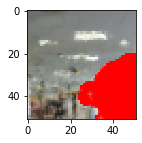

6
[[1.]]
True


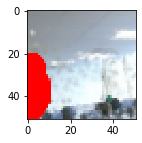

9
[[0.23708133]]
True


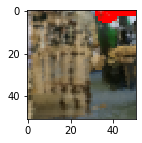

In [34]:
test = sliding_window(50, image)

def confidence_threshold(prediction):
    # Will return true if models confidence is above a threshold value
    threshold = 0.02
    if (prediction > threshold):
        return True
    else:
        return False

print(len(test[:,0,0,0]))

for i in range( len(test[:,0,0,0]) ):
    
    prediction = model.predict( np.array( [test[i,:,:,:],]) )

    if (confidence_threshold(prediction)==False):
        continue
    else:
        print(i)
        print(prediction)
        print(confidence_threshold(prediction))  
        #print( str(prediction).format(1.0e-9) ) # Force scientific notation off
        plt.figure(figsize=(4,2))
        plt.imshow(test[i,:,:,:])    
        plt.show()
